In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import os
from __future__ import print_function, division
from builtins import range, input
from glob import glob

import keras
from keras import backend as K
from keras import optimizers, losses, activations, models, applications

#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.models import Model, Sequential

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

print('Keras Version: ',keras.__version__)
print('Tensorflow Version: ',tf.__version__)

Using TensorFlow backend.


Keras Version:  2.2.4
Tensorflow Version:  1.14.0


In [0]:
#novel mkdir function
def mkdir(p):
  if not os.path.exists(p):
    os.mkdir(p)
    
def link(src, dst):
  if not os.path.exists(dst):
    os.symlink(src, dst, target_is_directory=True)

In [5]:
#check if dataset exists, if exists skip next cell
print(glob('drive/My Drive/ML/*'))

['drive/My Drive/ML/large_file', 'drive/My Drive/ML/vgg_tl.ipynb', 'drive/My Drive/ML/pneumonia_tl.ipynb', 'drive/My Drive/ML/TestFiles', 'drive/My Drive/ML/pneumonia_tl_inception.ipynb', 'drive/My Drive/ML/pneumonia_tl_vgg16_retrained.ipynb', 'drive/My Drive/ML/Copy of pneumonia_tl_vgg16.ipynb', 'drive/My Drive/ML/pneumonia_tl_vgg16.ipynb', 'drive/My Drive/ML/DL Sample Poster Mart_Evan_Raj.pub']


In [0]:
#mkdir('drive/My Drive/ML/large_file') 
#
#from zipfile import ZipFile
### Create a ZipFile Object and load sample.zip in it
#with ZipFile('drive/My Drive/ML/large_file/chest_xray.zip', 'r') as zipObj:
#   # Extract all the contents of zip file in different directory
#   zipObj.extractall('drive/My Drive/ML/large_file/')

In [0]:
train_path = 'drive/My Drive/ML/large_file/chest_xray/train'
valid_path = 'drive/My Drive/ML/large_file/chest_xray/val'
test_path = 'drive/My Drive/ML/large_file/chest_xray/test'

In [8]:
print(glob(train_path+'/*'))
print(glob(valid_path+'/*'))
print(glob(test_path+'/*'))

['drive/My Drive/ML/large_file/chest_xray/train/PNEUMONIA', 'drive/My Drive/ML/large_file/chest_xray/train/NORMAL']
['drive/My Drive/ML/large_file/chest_xray/val/PNEUMONIA', 'drive/My Drive/ML/large_file/chest_xray/val/NORMAL']
['drive/My Drive/ML/large_file/chest_xray/test/PNEUMONIA', 'drive/My Drive/ML/large_file/chest_xray/test/NORMAL']


In [0]:
#number of files
image_files = glob(train_path+'/*/*.jp*g')
valid_image_files = glob(valid_path+'/*/*.jp*g')
test_image_files = glob(test_path+'/*/*.jp*g')

#number of folders
folders=glob(train_path+'/*')

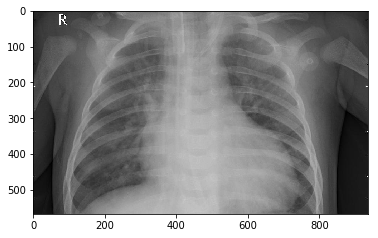

In [10]:
#load a random image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [0]:
#set image size, epochs and batch size
IMAGE_SIZE = [150,150]

epochs = 10
batch_size = 16

In [12]:
#import base model and freeze top x layers
base_model = VGG16(input_shape= IMAGE_SIZE + [3], weights='imagenet', include_top=False)


W0728 22:21:16.640580 140323296700288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 22:21:16.647724 140323296700288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 22:21:16.651604 140323296700288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 22:21:16.691190 140323296700288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0728 22:21:17.007604 140323296700288 deprecation_wrapp

In [13]:
x = Flatten()(base_model.output)

#x = Dense(units=256, activation='relu')(x)
#x = Dropout(rate=0.3)(x)
#x = Dense(units=512, activation='relu')(x)
#x = Dropout(rate=0.3)(x)

#x = GlobalAveragePooling2D()(x)
#x = Dropout(0.5)(x)

prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=prediction)


for layer in base_model.layers[0:20]:
  layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#model.summary()

def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))
        
print_layers(model)

W0728 22:21:17.798286 140323296700288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 22:21:17.819789 140323296700288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: False
layer 16: block5_conv2, trainable: False
layer 17: block5_conv3, trainable: False
layer 18: block5_pool, trainable: False
layer 19: flatten_1, trainable: True
layer 20: dense_1, trainable: True


In [14]:
model.trainable_weights

[<tf.Variable 'dense_1/kernel:0' shape=(8192, 2) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32_ref>]

In [0]:
#data augmentation
gen = ImageDataGenerator(
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.1,
    #zoom_range=0.1,
    #horizontal_flip=True,
    preprocessing_function=preprocess_input
)

In [16]:
#validation data without augmentation
test_gen = gen.flow_from_directory(test_path, target_size=IMAGE_SIZE)

print(test_gen.class_indices)

Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


W0728 22:21:22.087893 140323296700288 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -120.68 max: 151.061


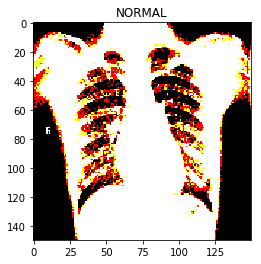

In [17]:
#get lables for CM
labels = [None]* len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
  labels[v] = k
  
for x, y in test_gen:
  print('min:', x[0].min(), 'max:', x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [18]:
train_generator = gen.flow_from_directory(
  train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

valid_generator = gen.flow_from_directory(
  valid_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

test_generator = gen.flow_from_directory(
  test_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [19]:

file_path="drive/My Drive/ML/large_file/chest_xray/weights.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='acc', verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor="acc", mode="max", patience=2)

callbacks_list = [checkpoint, early] 

r = model.fit_generator(train_generator, 
                        validation_data = test_generator,
                              epochs=epochs, 
                              shuffle=True, 
                              verbose=True,
                              steps_per_epoch = len(image_files) //batch_size,
                              validation_steps= len(test_image_files) //batch_size,
                              callbacks=callbacks_list)

Epoch 1/10
326/326 [==============================] - 1289s 4s/step - loss: 4.1258 - acc: 0.7416 - val_loss: 6.0113 - val_acc: 0.6250

Epoch 00001: acc improved from -inf to 0.74156, saving model to drive/My Drive/ML/large_file/chest_xray/weights.best.hdf5
Epoch 2/10
326/326 [==============================] - 70s 215ms/step - loss: 2.8254 - acc: 0.8140 - val_loss: 1.7536 - val_acc: 0.8638

Epoch 00002: acc improved from 0.74156 to 0.81403, saving model to drive/My Drive/ML/large_file/chest_xray/weights.best.hdf5
Epoch 3/10
326/326 [==============================] - 69s 211ms/step - loss: 0.5803 - acc: 0.9548 - val_loss: 2.9712 - val_acc: 0.7965

Epoch 00003: acc improved from 0.81403 to 0.95475, saving model to drive/My Drive/ML/large_file/chest_xray/weights.best.hdf5
Epoch 4/10
326/326 [==============================] - 69s 212ms/step - loss: 0.4550 - acc: 0.9645 - val_loss: 2.1510 - val_acc: 0.8526

Epoch 00004: acc improved from 0.95475 to 0.96453, saving model to drive/My Drive/ML/

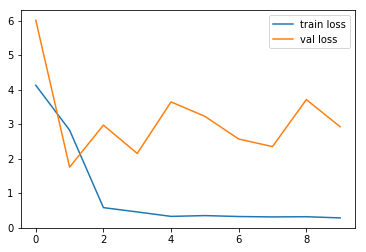

In [26]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

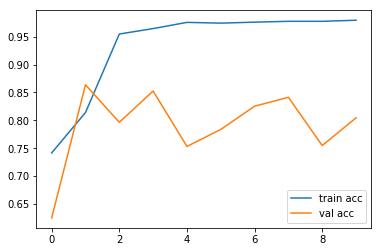

In [27]:

plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [0]:
#load weights from file
model.load_weights(file_path)

In [0]:
#taken directly from scickit learn docs on CM
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


def y2indicator(Y):
  K = len(set(Y))
  N = len(Y)
  I = np.empty((N, K))
  I[np.arange(N), Y] = 1
  return I

def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 8):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

Generating confusion matrix 5216
Found 5216 images belonging to 2 classes.
Confusion matrix, without normalization
[[1317   24]
 [  39 3836]]


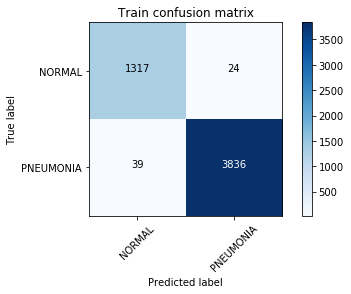

In [30]:
cm =  get_confusion_matrix(train_path, len(image_files))
#print(cm)
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plt.show()

Generating confusion matrix 624
Found 624 images belonging to 2 classes.
Confusion matrix, without normalization
[[115 119]
 [  3 387]]


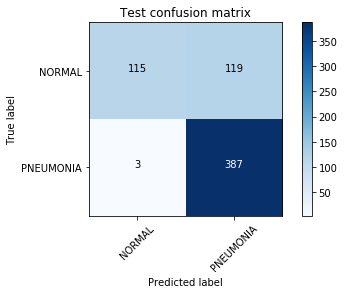

In [31]:
test_cm = get_confusion_matrix(test_path, len(test_image_files))
#print(valid_cm)
plot_confusion_matrix(test_cm, labels, title='Test confusion matrix')
plt.show()

In [33]:
# Calculate Precision and Recall
tn, fp, fn, tp = test_cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.76
